In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import sys
import time
import gc
import itertools
import tqdm
import time

from sklearn.preprocessing import LabelEncoder
import scipy.stats as ss

if os.name=='nt':
    try:
        mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'
        os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
    except:
        pass
    
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from numba import jit

%matplotlib inline

In [2]:
# Load data
train = pd.read_csv('all/sales_train.csv.gz')
test = pd.read_csv('all/test.csv.gz')
shop = pd.read_csv('all/shops-translated.csv')
item = pd.read_csv('all/item_category.csv')

test.set_index('ID', inplace=True)
item.drop(['item_name_translated'], axis=1, inplace=True)
shop.drop(['Name'], axis=1, inplace=True)

le = LabelEncoder()
item['item_cat1'] = le.fit_transform(item['item_cat1'].astype(str))
item['item_cat2'] = le.fit_transform(item['item_cat2'].astype(str))
shop['City'] = le.fit_transform(shop['City'])
shop['Type'] = le.fit_transform(shop['Type'])

# test = test.merge(item, on='item_id', how='left')
# test = test.merge(shop, on='shop_id', how='left')

In [3]:
# count of sales per month
cnt = train.pivot_table(index=['shop_id', 'item_id'],
                        columns=['date_block_num'],
                        values='item_cnt_day',
                        aggfunc='sum').fillna(0.0)

cnt = test.join(cnt, on=['shop_id', 'item_id'], how='left').fillna(0.0)
cnt.drop(['shop_id', 'item_id'], axis=1, inplace=True)
cnt.columns = ['cnt_'+str(k) for k in cnt.columns]

In [4]:
# total value of sales per month
train['sales'] = train['item_cnt_day']*train['item_price']
sales = train.pivot_table(index=['shop_id', 'item_id'],
                         columns='date_block_num',
                         values='sales',
                         aggfunc=np.sum).fillna(0.0)

sales = test.join(sales, on=['shop_id', 'item_id'], how='left').fillna(0.0)
sales.drop(['shop_id', 'item_id'], axis=1, inplace=True)
sales.columns = ['sales_'+str(k) for k in sales.columns]

In [5]:
test_shop_item = test.merge(shop, on=['shop_id'], how='left')
test_shop_item = test_shop_item.merge(item, on=['item_id'], how='left')

### Mean Encoding

In [6]:
# Apply pivot table with combinations of the following parameters
index_list = ['item_id', 'shop_id', 'City', 'Type', 'item_cat1', 'item_cat2']
column_list = ['date_block_num']
value_list = ['item_price', 'item_cnt_day', 'sales'] # ['item_price', 'item_cnt_day', 'sales']
aggfunc_list = [np.sum, np.mean]

In [7]:
x = train.merge(shop, on='shop_id', how='left')
x = x.merge(item, on='item_id', how='left')

In [8]:
cols_drop = ['shop_id', 'item_id', 'City', 'Type', 'item_cat1', 'item_cat2']

In [9]:
feature_dict2 = {}
for idx, col, val, agf in tqdm.tqdm_notebook(list(itertools.product(index_list, column_list, value_list, aggfunc_list))):
    tmp = x.pivot_table(index=idx, columns=col, values=val, aggfunc=agf).fillna(0.0)
    tmp_name = '-'.join([idx, val, str(agf).split(' ')[1]])
    tmp.columns = [tmp_name+'_'+str(k) for k in tmp.columns]
    tmp = test_shop_item.merge(tmp, on=idx, how='left').fillna(0.0)
    tmp.drop(cols_drop, axis=1, inplace=True)
    feature_dict2[tmp_name] = tmp

In [10]:
feature_dict2.keys()

dict_keys(['item_id-item_price-sum', 'item_id-item_price-mean', 'item_id-item_cnt_day-sum', 'item_id-item_cnt_day-mean', 'item_id-sales-sum', 'item_id-sales-mean', 'shop_id-item_price-sum', 'shop_id-item_price-mean', 'shop_id-item_cnt_day-sum', 'shop_id-item_cnt_day-mean', 'shop_id-sales-sum', 'shop_id-sales-mean', 'City-item_price-sum', 'City-item_price-mean', 'City-item_cnt_day-sum', 'City-item_cnt_day-mean', 'City-sales-sum', 'City-sales-mean', 'Type-item_price-sum', 'Type-item_price-mean', 'Type-item_cnt_day-sum', 'Type-item_cnt_day-mean', 'Type-sales-sum', 'Type-sales-mean', 'item_cat1-item_price-sum', 'item_cat1-item_price-mean', 'item_cat1-item_cnt_day-sum', 'item_cat1-item_cnt_day-mean', 'item_cat1-sales-sum', 'item_cat1-sales-mean', 'item_cat2-item_price-sum', 'item_cat2-item_price-mean', 'item_cat2-item_cnt_day-sum', 'item_cat2-item_cnt_day-mean', 'item_cat2-sales-sum', 'item_cat2-sales-mean'])

### CV

In [11]:
month_in_model = 31
month_test = 34
month_in_cv = list(range(month_in_model, 35))
cols_cv = {k: list(range(k-month_in_model, k)) for k in month_in_cv} # The last month is test

x_train = {}
y_train = {}
for m in month_in_cv:
    print(m)
    df_list = [test_shop_item, 
           cnt.iloc[:, cols_cv[m]], 
           sales.iloc[:, cols_cv[m]]]
    df_list.extend([feature_dict2[k].iloc[:, cols_cv[m]] 
                    for k in feature_dict2.keys()])
    x_train[m] = pd.concat(df_list, axis=1, sort=False).values
    if m<month_test:
        # only train months have y_train, test month does not have it
        # clip ground truth since the objective is clipped
        y_train[m] = np.maximum(np.minimum(cnt.iloc[:, m].values, 40.0), 0.0)

In [13]:
def clip_rmse(preds, dtrain):
    y_test = np.array(dtrain.get_label())
    preds = np.array(preds)
    y_test = np.maximum(np.minimum(y_test, 20), 0)
    preds = np.maximum(np.minimum(preds, 20), 0)
    #preds = np.array(list(map(lambda x: min(20, max(x, 0)), list(preds))))
    #y_test = np.array(list(map(lambda x: min(20, max(x, 0)), list(y_test))))
    rmse = np.sqrt(mean_squared_error(preds,y_test))
    return 'clip-rmse', rmse

In [14]:
def cv_predict(param, n_tree, x_train, y_train, month_in_cv, sub_name, verbose=False):
    '''CV and predict'''
    progress = dict()
    bst_cv = dict()
    
    for m in month_in_cv:
        if m<month_in_cv[-2]:
            # CV 
            print('CV of month {} is started.'.format(m))
            time_start = time.time()
            progress[m] = {}
            dtrain = xgb.DMatrix(x_train[m], y_train[m], nthread=-1)
            dval = xgb.DMatrix(x_train[m+1], y_train[m+1], nthread=-1)
            watchlist = [(dtrain, 'train'), (dval, 'val')]

            bst_cv[m] = xgb.train(param, 
                            dtrain, 
                            evals=watchlist,
                            evals_result=progress[m], 
                            verbose_eval=verbose,
                            num_boost_round=n_tree,
                            feval=clip_rmse)

            time_end = time.time()

            print('CV of month {} is finished, uses {:.2f} sec, clip-rmse on val {:.2f}\n'.format(m, 
                time_end-time_start, progress[m]['val']['clip-rmse'][-1]))
            
        elif m==month_in_cv[-2]:
            # Train the last cv model for prediction
            print('Training of month {} is started.'.format(m))
            time_start = time.time()
            dtrain = xgb.DMatrix(x_train[m], y_train[m], nthread=-1)
            watchlist = [(dtrain, 'train')]

            bst_cv[m] = xgb.train(param, 
                            dtrain, 
                            evals=watchlist,
                            verbose_eval=verbose,
                            num_boost_round=n_tree,
                            feval=clip_rmse)

            time_end = time.time()
            print('Train of month {} is finished, uses {:.2f} sec.\n'.format(m, time_end-time_start))
                  
        else:
            # Prediction
            print('Predicting of month {} is started.'.format(m))
            preds = bst_cv[m-1].predict(xgb.DMatrix(x_train[m]))
            preds = list(map(lambda x: min(20, max(x, 0)), list(preds)))
            sub_df = pd.DataFrame({'ID': cnt.index, 'item_cnt_month': preds})
            sub_df.to_csv(sub_name, index=False)
            print('Prediction of month {} is finished.\n'.format(m))
        
    progress = {m: {'train': progress[m]['train']['clip-rmse'], 
            'val': progress[m]['val']['clip-rmse']} 
        for m in progress.keys()}
    progress = pd.DataFrame({(m, k): progress[m][k] 
                             for m in progress.keys() 
                             for k in progress[m].keys()})
    
    return progress, bst_cv, sub_df

In [ ]:
param = {'max_depth':14, 
         'subsample':0.9,
         'min_child_weight':3,
         'eta':0.03, 
         'lambda':2,
         'colsample_bytree':0.6,
         'seed':1,
         'silent':1,
         'eval_metric':'rmse',
         'maximize': False,
         'nthread':8}
n_tree = 40

progress, bst_cv, sub_df = cv_predict(param, n_tree, x_train, y_train, month_in_cv, 'eda_11.csv', verbose=True)

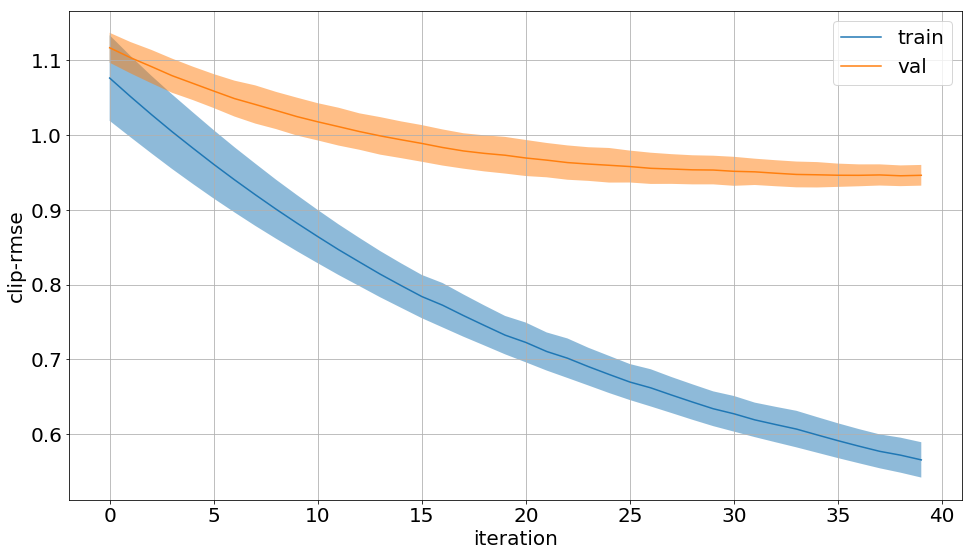

In [16]:
val_mean = progress.xs('val', axis=1, level=1).mean(axis=1)
val_std = progress.xs('val', axis=1, level=1).std(axis=1)

train_mean = progress.xs('train', axis=1, level=1).mean(axis=1)
train_std = progress.xs('train', axis=1, level=1).std(axis=1)

plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 20})
plt.plot(np.arange(len(train_mean)), train_mean)
plt.fill_between(np.arange(len(train_std)), 
                 train_mean-train_std, 
                 train_mean+train_std, alpha=0.5)
plt.plot(np.arange(len(val_mean)), val_mean)
plt.fill_between(np.arange(len(val_mean)), 
                 val_mean-val_std, 
                 val_mean+val_std, alpha=0.5)
plt.legend(['train', 'val'])
plt.xlabel('iteration')
plt.ylabel('clip-rmse')
plt.grid()

### Ensemble

In [35]:
def ensemble(n_model, param, n_tree, x_train, y_train, month_in_cv, sub_name, verbose=True, random_state=42):
    '''Change random seed and train, then combine predictions'''
    
    np.random.seed(random_state)
    
    bst = {}
    preds = []
    m = month_in_cv[-2]
    
    for n in range(n_model):
        # Train the model with a different random seed
        param['seed'] = np.random.randint(100000)
        
        # Train the last cv model for prediction
        print('Start training model {} on month {}'.format(n, m))
        time_start = time.time()
        dtrain = xgb.DMatrix(x_train[m], y_train[m], nthread=-1)
        watchlist = [(dtrain, 'train')]

        bst[n] = xgb.train(param, 
                        dtrain, 
                        evals=watchlist,
                        verbose_eval=verbose,
                        num_boost_round=n_tree,
                        feval=clip_rmse)

        time_end = time.time()
        print('Train of model {} on month {} is finished, uses {:.2f} sec.\n'.format(n, m, time_end-time_start))

        # Prediction
        print('Start predicting model {} on month {}.'.format(n, m+1))
        preds.append(bst[n].predict(xgb.DMatrix(x_train[m+1])))
        print('Prediction of model {} on month {} is finished.\n'.format(n, m+1))
        
        print('---------------------------------------\n')
    
    preds_mean = np.array(preds).mean(axis=0)
    preds_mean = list(map(lambda x: min(20, max(x, 0)), list(preds_mean)))
    preds_mean = pd.DataFrame({'ID': cnt.index, 'item_cnt_month': preds_mean})
    preds_mean.to_csv(sub_name, index=False)
    
    
    return bst, preds, preds_mean

In [ ]:
param = {'max_depth':14, 
         'subsample':0.9,
         'min_child_weight':3,
         'eta':0.03, 
         'lambda':2,
         'colsample_bytree':0.8,
         'seed':1,
         'silent':1,
         'eval_metric':'rmse',
         'maximize': False,
         'nthread':8}
n_tree = 40
n_model = 10

bst, preds, preds_mean = ensemble(n_model, param, n_tree, x_train, y_train, month_in_cv, 'eda_11.csv', verbose=True)

In [60]:
a = {k: bst[k].get_score(importance_type='gain') for k in range(n_model)}

In [61]:
a = pd.DataFrame(a)

In [66]:
a.index = [int(k[1:]) for k in a.index]

In [78]:
b = a.mean(axis=1).sort_values(ascending=False)

In [85]:
important_features = b.iloc[:100].index.tolist()

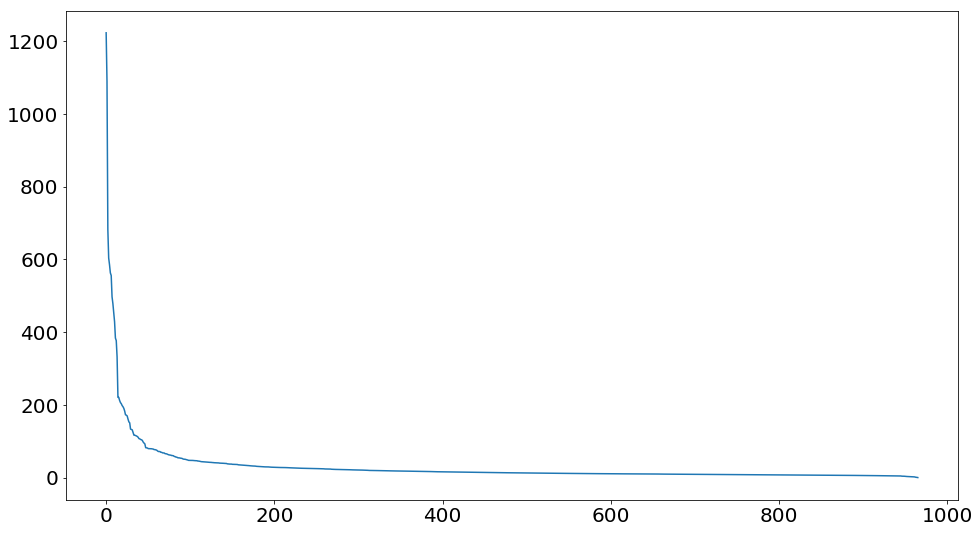

In [75]:
plt.figure(figsize=(16, 9))
plt.plot(a.mean(axis=1).sort_values(ascending=False).values)

### Train with important 100 features

In [86]:
month_in_model = 31
month_test = 34
month_in_cv = list(range(month_in_model, 35))
cols_cv = {k: list(range(k-month_in_model, k)) for k in month_in_cv} # The last month is test

x_train = {}
y_train = {}
for m in month_in_cv:
    print(m)
    df_list = [test_shop_item, 
           cnt.iloc[:, cols_cv[m]], 
           sales.iloc[:, cols_cv[m]]]
    df_list.extend([feature_dict2[k].iloc[:, cols_cv[m]] 
                    for k in feature_dict2.keys()])
    x_train[m] = pd.concat(df_list, axis=1, sort=False).values[:, important_features]
    if m<month_test:
        # only train months have y_train, test month does not have it
        # clip ground truth since the objective is clipped
        y_train[m] = np.maximum(np.minimum(cnt.iloc[:, m].values, 40.0), 0.0)

31
32
33
34


In [87]:
param = {'max_depth':14, 
         'subsample':0.9,
         'min_child_weight':3,
         'eta':0.03, 
         'lambda':2,
         'colsample_bytree':0.6,
         'seed':1,
         'silent':1,
         'eval_metric':'rmse',
         'maximize': False,
         'nthread':8}
n_tree = 40

progress, bst_cv, sub_df = cv_predict(param, n_tree, x_train, y_train, month_in_cv, 'eda_11.csv', verbose=True)

CV of month 31 is started.
[0]	train-rmse:1.18696	val-rmse:1.38768	train-clip-rmse:1.03891	val-clip-rmse:1.13017
[1]	train-rmse:1.16333	val-rmse:1.37394	train-clip-rmse:1.01664	val-clip-rmse:1.11682
[2]	train-rmse:1.1409	val-rmse:1.36023	train-clip-rmse:0.99542	val-clip-rmse:1.10367
[3]	train-rmse:1.12145	val-rmse:1.34825	train-clip-rmse:0.977015	val-clip-rmse:1.09231
[4]	train-rmse:1.10041	val-rmse:1.33738	train-clip-rmse:0.95734	val-clip-rmse:1.08169
[5]	train-rmse:1.08259	val-rmse:1.32609	train-clip-rmse:0.940538	val-clip-rmse:1.07096
[6]	train-rmse:1.06224	val-rmse:1.31489	train-clip-rmse:0.921689	val-clip-rmse:1.06047
[7]	train-rmse:1.04338	val-rmse:1.30463	train-clip-rmse:0.904508	val-clip-rmse:1.05105
[8]	train-rmse:1.02659	val-rmse:1.29416	train-clip-rmse:0.889086	val-clip-rmse:1.04131
[9]	train-rmse:1.00783	val-rmse:1.28366	train-clip-rmse:0.87193	val-clip-rmse:1.03165
[10]	train-rmse:0.989646	val-rmse:1.27522	train-clip-rmse:0.855247	val-clip-rmse:1.02415
[11]	train-rmse:0.97

[19]	train-rmse:0.994936	train-clip-rmse:0.802647
[20]	train-rmse:0.984732	train-clip-rmse:0.7942
[21]	train-rmse:0.975083	train-clip-rmse:0.786349
[22]	train-rmse:0.960584	train-clip-rmse:0.774505
[23]	train-rmse:0.945939	train-clip-rmse:0.762437
[24]	train-rmse:0.937309	train-clip-rmse:0.755555
[25]	train-rmse:0.92308	train-clip-rmse:0.744281
[26]	train-rmse:0.914773	train-clip-rmse:0.737709
[27]	train-rmse:0.901464	train-clip-rmse:0.727248
[28]	train-rmse:0.88858	train-clip-rmse:0.71713
[29]	train-rmse:0.876194	train-clip-rmse:0.7075
[30]	train-rmse:0.86437	train-clip-rmse:0.698248
[31]	train-rmse:0.852616	train-clip-rmse:0.689197
[32]	train-rmse:0.84159	train-clip-rmse:0.680966
[33]	train-rmse:0.83092	train-clip-rmse:0.672938
[34]	train-rmse:0.820502	train-clip-rmse:0.665317
[35]	train-rmse:0.810674	train-clip-rmse:0.658017
[36]	train-rmse:0.80457	train-clip-rmse:0.653416
[37]	train-rmse:0.798842	train-clip-rmse:0.649047
[38]	train-rmse:0.793548	train-clip-rmse:0.645082
[39]	train-

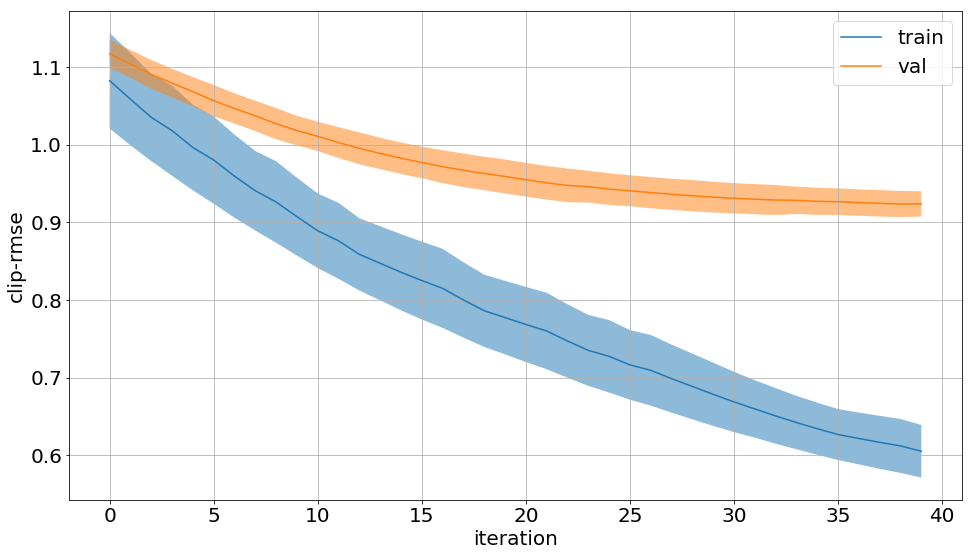

In [89]:
val_mean = progress.xs('val', axis=1, level=1).mean(axis=1)
val_std = progress.xs('val', axis=1, level=1).std(axis=1)

train_mean = progress.xs('train', axis=1, level=1).mean(axis=1)
train_std = progress.xs('train', axis=1, level=1).std(axis=1)

plt.figure(figsize=(16, 9))
plt.rcParams.update({'font.size': 20})
plt.plot(np.arange(len(train_mean)), train_mean)
plt.fill_between(np.arange(len(train_std)), 
                 train_mean-train_std, 
                 train_mean+train_std, alpha=0.5)
plt.plot(np.arange(len(val_mean)), val_mean)
plt.fill_between(np.arange(len(val_mean)), 
                 val_mean-val_std, 
                 val_mean+val_std, alpha=0.5)
plt.legend(['train', 'val'])
plt.xlabel('iteration')
plt.ylabel('clip-rmse')
plt.grid()

In [91]:
param = {'max_depth':14, 
         'subsample':0.9,
         'min_child_weight':3,
         'eta':0.03, 
         'lambda':2,
         'colsample_bytree':0.8,
         'seed':1,
         'silent':1,
         'eval_metric':'rmse',
         'maximize': False,
         'nthread':8}
n_tree = 40
n_model = 10

bst, preds, preds_mean = ensemble(n_model, param, n_tree, x_train, y_train, month_in_cv, 'eda_11.csv', verbose=False)

Start training model 0 on month 33
Train of model 0 on month 33 is finished, uses 13.44 sec.

Start predicting model 0 on month 34.
Prediction of model 0 on month 34 is finished.

---------------------------------------

Start training model 1 on month 33
Train of model 1 on month 33 is finished, uses 13.64 sec.

Start predicting model 1 on month 34.
Prediction of model 1 on month 34 is finished.

---------------------------------------

Start training model 2 on month 33
Train of model 2 on month 33 is finished, uses 13.56 sec.

Start predicting model 2 on month 34.
Prediction of model 2 on month 34 is finished.

---------------------------------------

Start training model 3 on month 33
Train of model 3 on month 33 is finished, uses 13.46 sec.

Start predicting model 3 on month 34.
Prediction of model 3 on month 34 is finished.

---------------------------------------

Start training model 4 on month 33
Train of model 4 on month 33 is finished, uses 14.33 sec.

Start predicting model